<a href="https://www.kaggle.com/code/briankimanzi/fire-smoke-detection?scriptVersionId=293938905" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
!pip install ultralytics
!pip install roboflow
!pip install ruamel.yaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 25.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 121.0 MB/s eta 0:00:0000:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the 

In [4]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ultralytics
from ultralytics import YOLO
from roboflow import Roboflow
from IPython.display import Image 
from kaggle_secrets import UserSecretsClient
import yaml
from pprint import pprint
import cv2
import os 
import warnings 
warnings.filterwarnings("ignore")
ultralytics.checks()

Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6634.3/8062.4 GB disk)


# Data inspection and validation

In [5]:
image_sample = cv2.imread("/kaggle/input/smoke-fire-detection-yolo/data/train/images/AoF00005.jpg")
x , y , c = image_sample.shape 
print(f"The dimension af image {y} x {x} and {c} channels")

The dimension af image 1280 x 720 and 3 channels


In [6]:
BASE_PATH = "/kaggle/input/smoke-fire-detection-yolo/data"

splits = ["train", "val", "test"]

def check_split(split):
    img_dir = os.path.join(BASE_PATH, split, "images")
    lbl_dir = os.path.join(BASE_PATH, split, "labels")

    images = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    labels = [f for f in os.listdir(lbl_dir) if f.endswith(".txt")]

    img_names = set(os.path.splitext(f)[0] for f in images)
    lbl_names = set(os.path.splitext(f)[0] for f in labels)

    missing_labels = img_names - lbl_names
    missing_images = lbl_names - img_names

    print(f"\n {split}")
    print(f"Images : {len(images)}")
    print(f"Labels : {len(labels)}")

    if not missing_labels and not missing_images:
        print("All images and labels are matched")
    else:
        print(f"Missing labels for {len(missing_labels)} images")
        print(f"Missing Images for {len(missing_images)} labels")

for split in splits:
    check_split(split)


 train
Images : 14122
Labels : 14122
All images and labels are matched

 val
Images : 3099
Labels : 3099
All images and labels are matched

 test
Images : 4306
Labels : 4306
All images and labels are matched


# YAML Cofiguration for YOLO
YOLO uses a Yaml file to define dataset paths and class name 

In [7]:
# original YAML file
path_yaml_file = "/kaggle/input/smoke-fire-detection-yolo/data.yaml"

print("Content of Original yaml file")
with open(path_yaml_file, 'r') as file:
    data = yaml.safe_load(file)
    print(data)

Content of Original yaml file
{'path': '/kaggle/working/D Fire Dataset', 'train': 'data/train/images', 'val': 'data/val/images', 'test': 'data/test/images', 'names': ['smoke', 'fire'], 'nc': 2, 'train_count': 14122, 'val_count': 3099, 'test_count': 4306}


In [8]:
# valid path
input_file_path = '/kaggle/input/smoke-fire-detection-yolo/data.yaml'
output_file_path = '/kaggle/working/data.yaml'

with open(input_file_path, 'r') as file:
    data = yaml.safe_load(file)

base_path = '/kaggle/input/smoke-fire-detection-yolo/data'
data['path'] = base_path
data['train'] = f"{base_path}/train/images"
data['val'] = f"{base_path}/val/images"
data['test'] = f"{base_path}/test/images"

with open(output_file_path, 'w') as file:
    yaml.safe_dump(data, file, sort_keys=False)

print(f"Updated YAML saved to: {output_file_path}")
pprint(data)

Updated YAML saved to: /kaggle/working/data.yaml
{'names': ['smoke', 'fire'],
 'nc': 2,
 'path': '/kaggle/input/smoke-fire-detection-yolo/data',
 'test': '/kaggle/input/smoke-fire-detection-yolo/data/test/images',
 'test_count': 4306,
 'train': '/kaggle/input/smoke-fire-detection-yolo/data/train/images',
 'train_count': 14122,
 'val': '/kaggle/input/smoke-fire-detection-yolo/data/val/images',
 'val_count': 3099}


# Checking Dataset Balance
To ensure the model learns effectively, we check the distribution of classes across the dataset splits(train, val, test)

In [9]:
# To check the Balance Data
from collections import defaultdict

def read_yolo(dataset_metadata):
    train_path = dataset_metadata['train'].replace('images', 'labels')
    val_path = dataset_metadata['val'].replace('images', 'labels')
    test_path = dataset_metadata['test'].replace('images', 'labels')

    split_stats = {
        'train': defaultdict(int),
        'val' : defaultdict(int),
        'test' : defaultdict(int)
    }
    def process_labels(label_dir, split_name):
        if not os.path.exists(label_dir):
            raise FileNotFoundError(f"Labels folder not found: {label_dir}")


        for label_file in os.listdir(label_dir):
            if not label_file.endswith(".txt"):
                continue


            label_path = os.path.join(label_dir, label_file)


            with open(label_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]


            # Images withiout Objects
            if not lines:
                split_stats[split_name]['background'] += 1
                continue


            present_classes = set()
            for line in lines:
                class_id = int(line.split()[0])
                present_classes.add(class_id)


            if 0 in present_classes and 1 in present_classes:
                split_stats[split_name]['both'] += 1
            elif 1 in present_classes:
                split_stats[split_name]['fire_only'] += 1
            elif 0 in present_classes:
                split_stats[split_name]['smoke_only'] += 1
            else:
                split_stats[split_name]['background'] += 1
            
    process_labels(train_path, 'train')
    process_labels(val_path, 'val')
    process_labels(test_path, 'test')

    return split_stats
            

In [10]:
dataset_metadata = {'names': ['smoke', 'fire'],
'nc': 2,
'path': '/kaggle/input/smoke-fire-detection-yolo/data',
'test': '/kaggle/input/smoke-fire-detection-yolo/data/test/images',
'test_count': 4306,
'train': '/kaggle/input/smoke-fire-detection-yolo/data/train/images',
'train_count' : 14122,
'val' : '/kaggle/input/smoke-fire-detection-yolo/data/val/images',
'val_count' :3099}

# Fire and Smoke Distribution report
we summarize the class distribution in each dataset split to understand balance

In [11]:
stats = read_yolo(dataset_metadata)

print("Fire / Smoke Distribution Report\n")

for split in ['train', 'val', 'test']:
    s = stats[split]
    total = sum(s.values())

    print(f"{split.upper()} SET ({total} images)")
    print(f"- Fire only     : {s['fire_only']} ({s['fire_only']/total:.1%})")
    print(f"- Smoke only    : {s['smoke_only']} ({s['smoke_only']/total:.1%})")
    print(f"- Both present  : {s['both']} ({s['both']/total:.1%})")
    print(f"- Background    : {s['background']} ({s['background']/total:.1%})")
    print()

Fire / Smoke Distribution Report

TRAIN SET (14122 images)
- Fire only     : 770 (5.5%)
- Smoke only    : 3836 (27.2%)
- Both present  : 3058 (21.7%)
- Background    : 6458 (45.7%)

VAL SET (3099 images)
- Fire only     : 174 (5.6%)
- Smoke only    : 845 (27.3%)
- Both present  : 705 (22.7%)
- Background    : 1375 (44.4%)

TEST SET (4306 images)
- Fire only     : 220 (5.1%)
- Smoke only    : 1186 (27.5%)
- Both present  : 895 (20.8%)
- Background    : 2005 (46.6%)



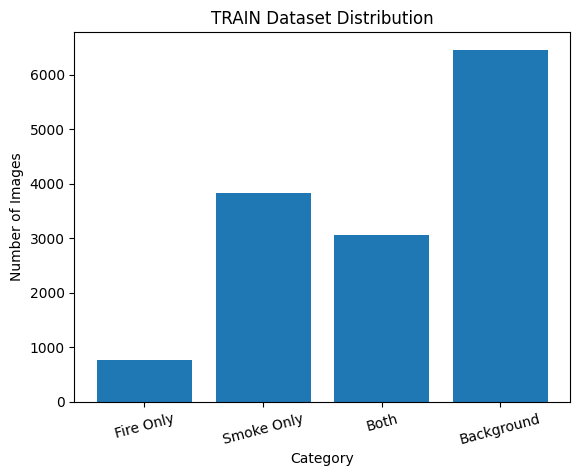

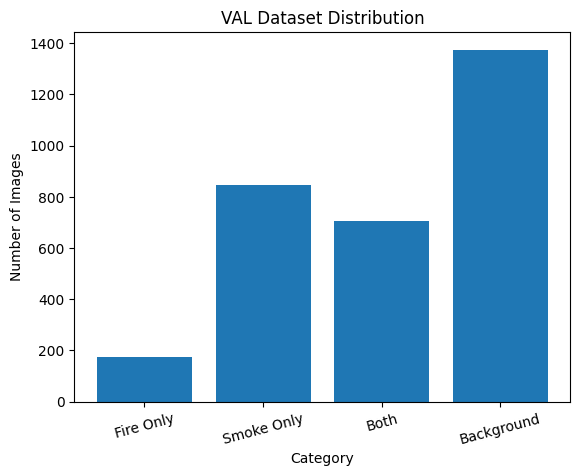

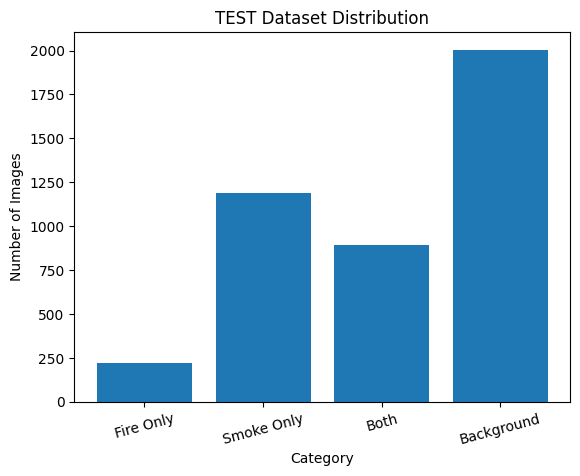

In [12]:
# Data Visualization
labels = ['Fire Only', 'Smoke Only', 'Both', 'Background']

for split in ['train', 'val', 'test']:
    values = [
        stats[split]['fire_only'],
        stats[split]['smoke_only'],
        stats[split]['both'],
        stats[split]['background']
        
    ]
    plt.figure()
    plt.bar(labels, values)
    plt.title(f"{split.upper()} Dataset Distribution")
    plt.xlabel("Category")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=15)
    plt.show()

# YOLOv8 Model Training
Train a YOLOv8 model for fire and smoke detection using the prepared dataset and YAML configuration

In [13]:
#%%capture cell
!yolo task=detect mode=train \
data=/kaggle/working/data.yaml \
model=yolov8s.pt \
epochs=150 \
imgsz=640 \
batch=32 \
patience=20 \
verbose=False

Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, po

# Confusion Matrix Visualization
After training, we visualize the confusion matrix to evaluate how well the model distinguishes between fire and smoke classes

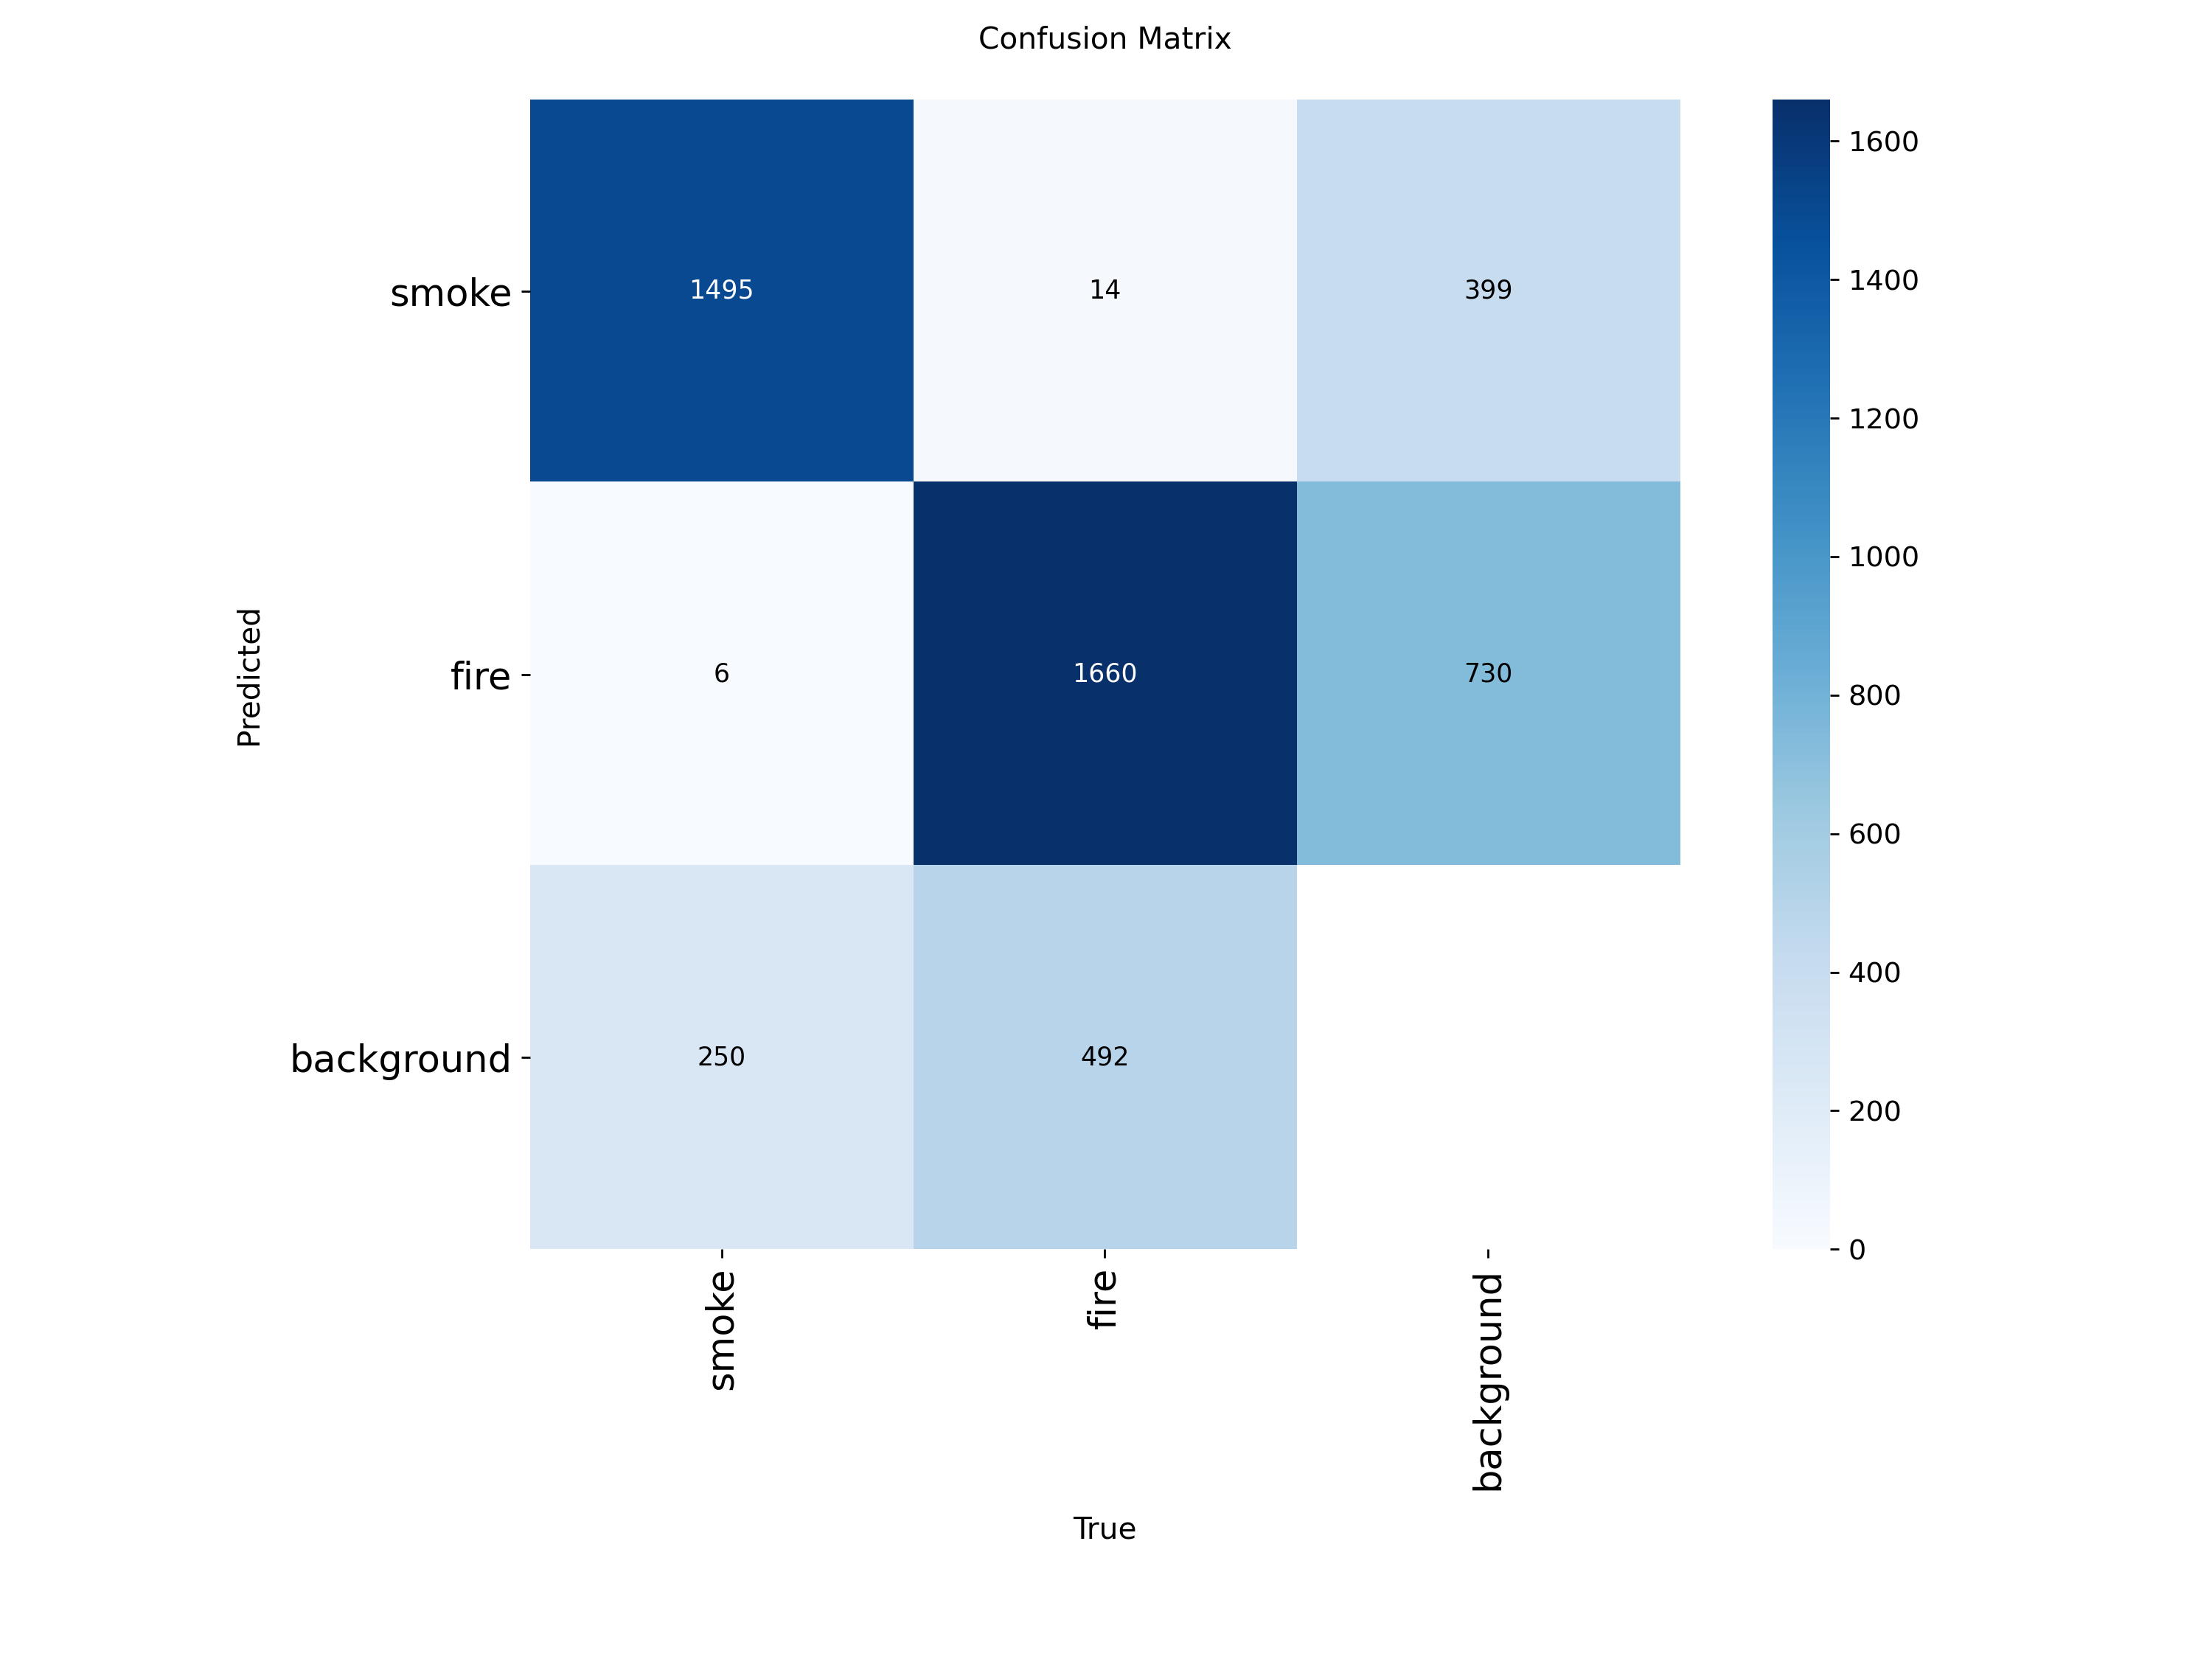

In [14]:
Image("/kaggle/working/runs/detect/train/confusion_matrix.png", width=600)

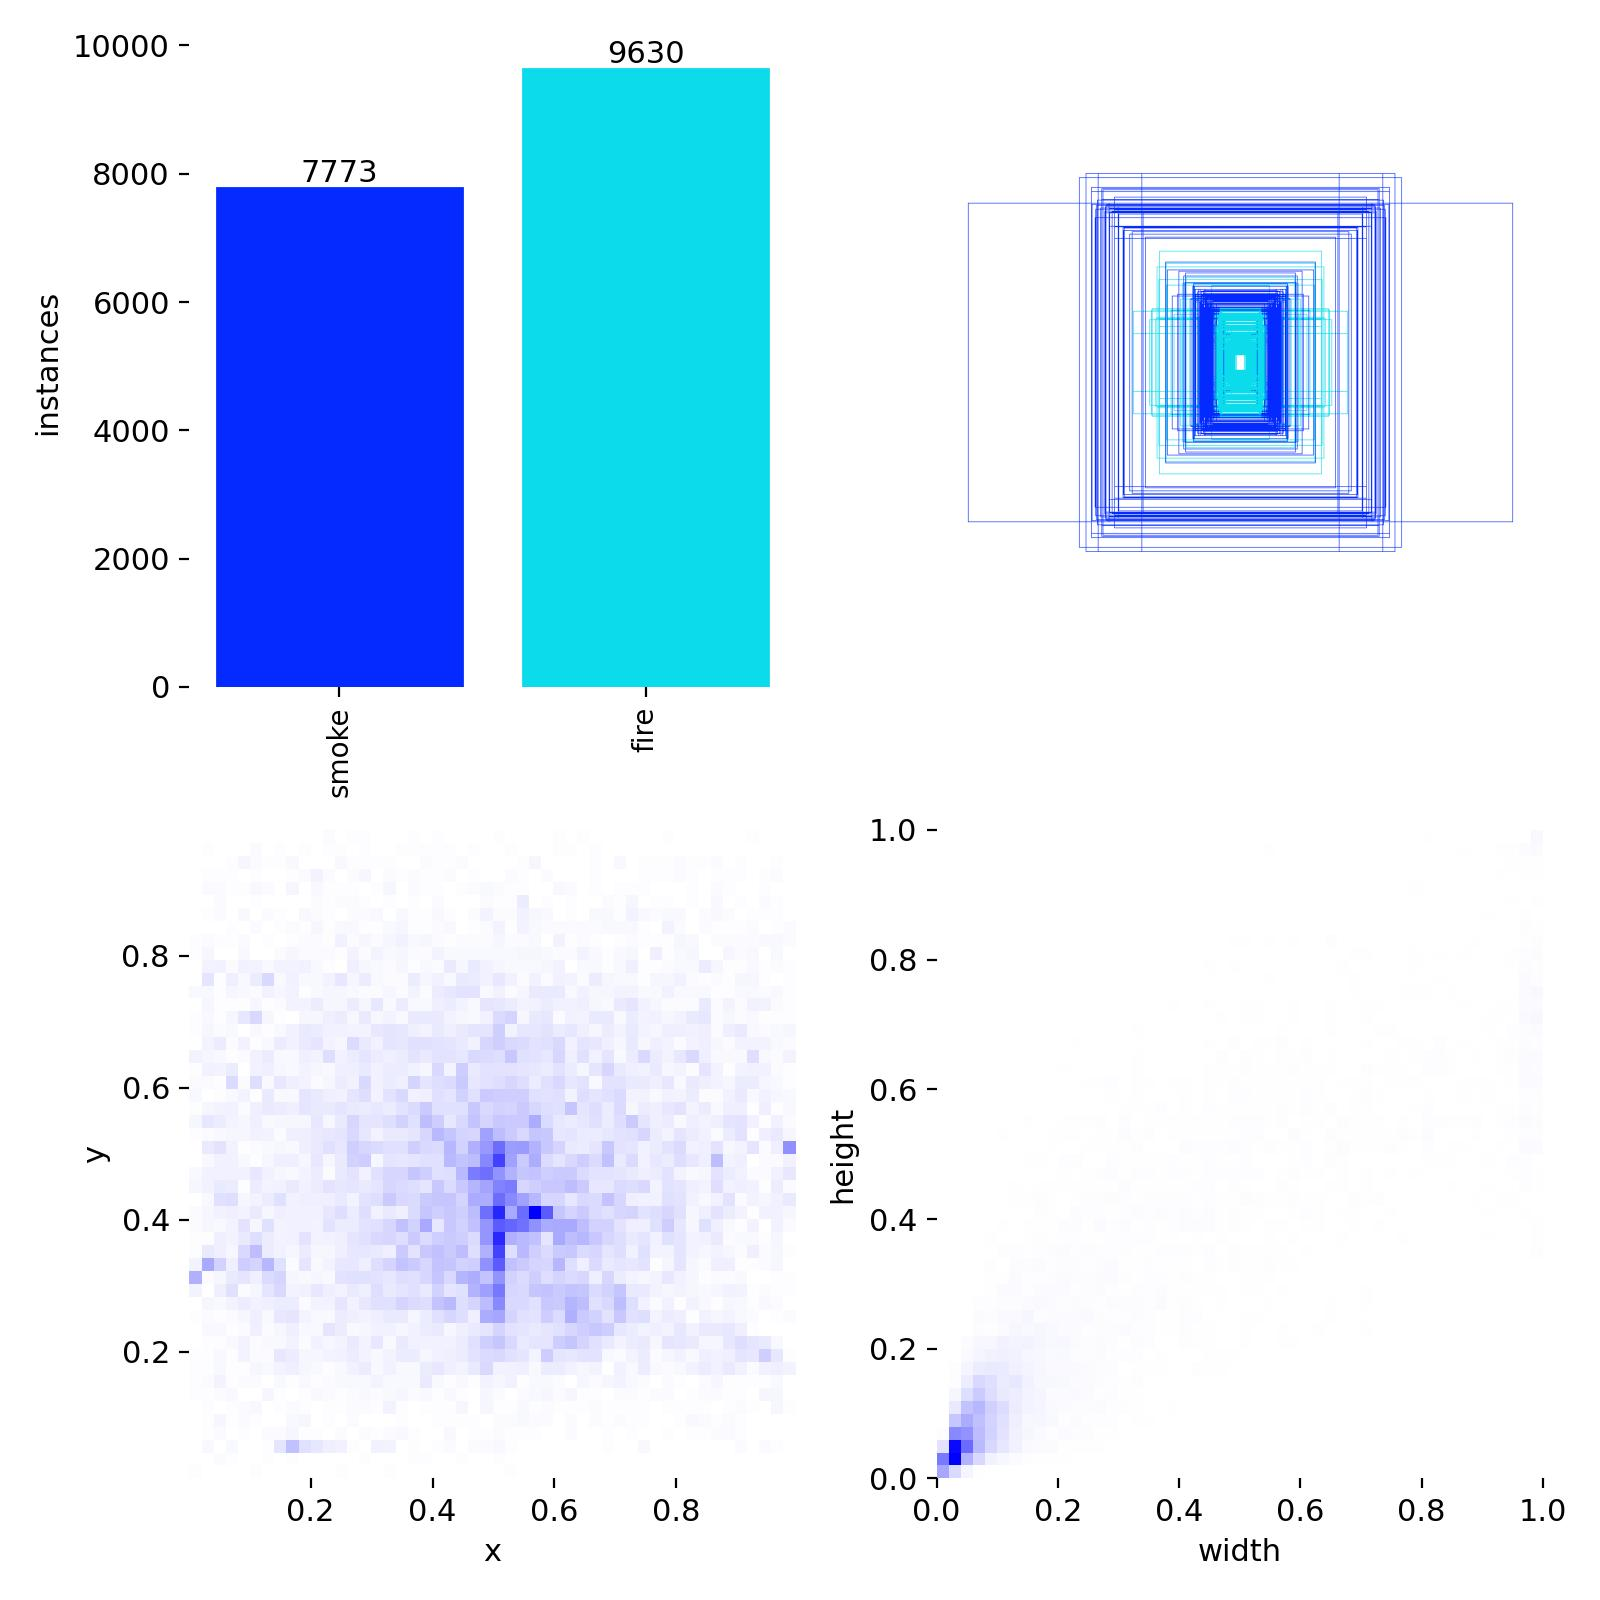

In [15]:
Image("/kaggle/working/runs/detect/train/labels.jpg", width=600)

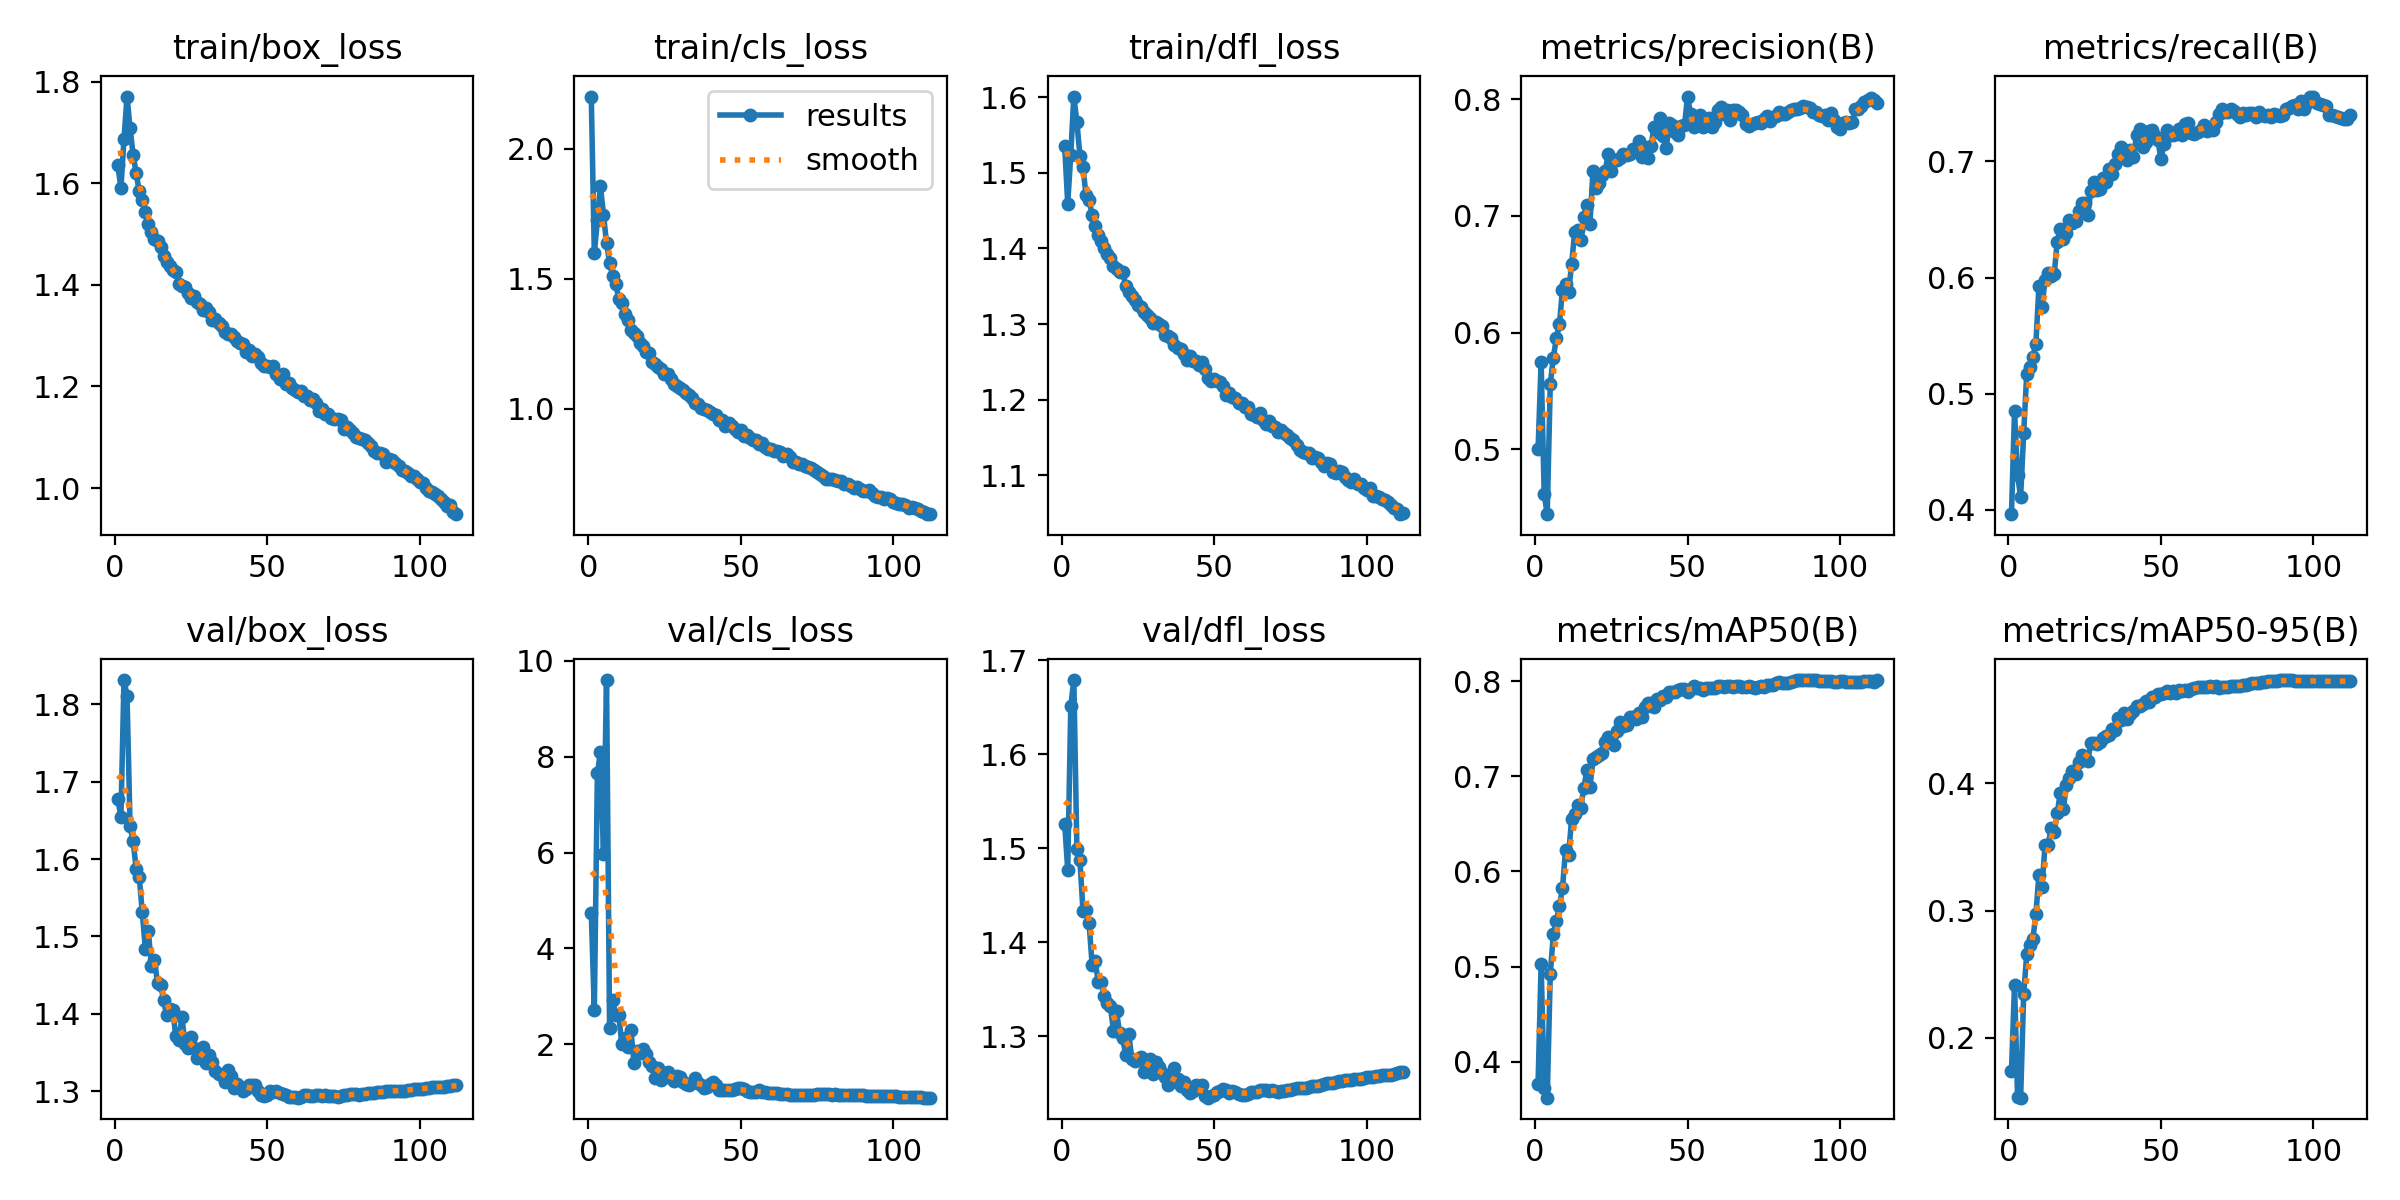

In [16]:
Image("/kaggle/working/runs/detect/train/results.png", width=600)

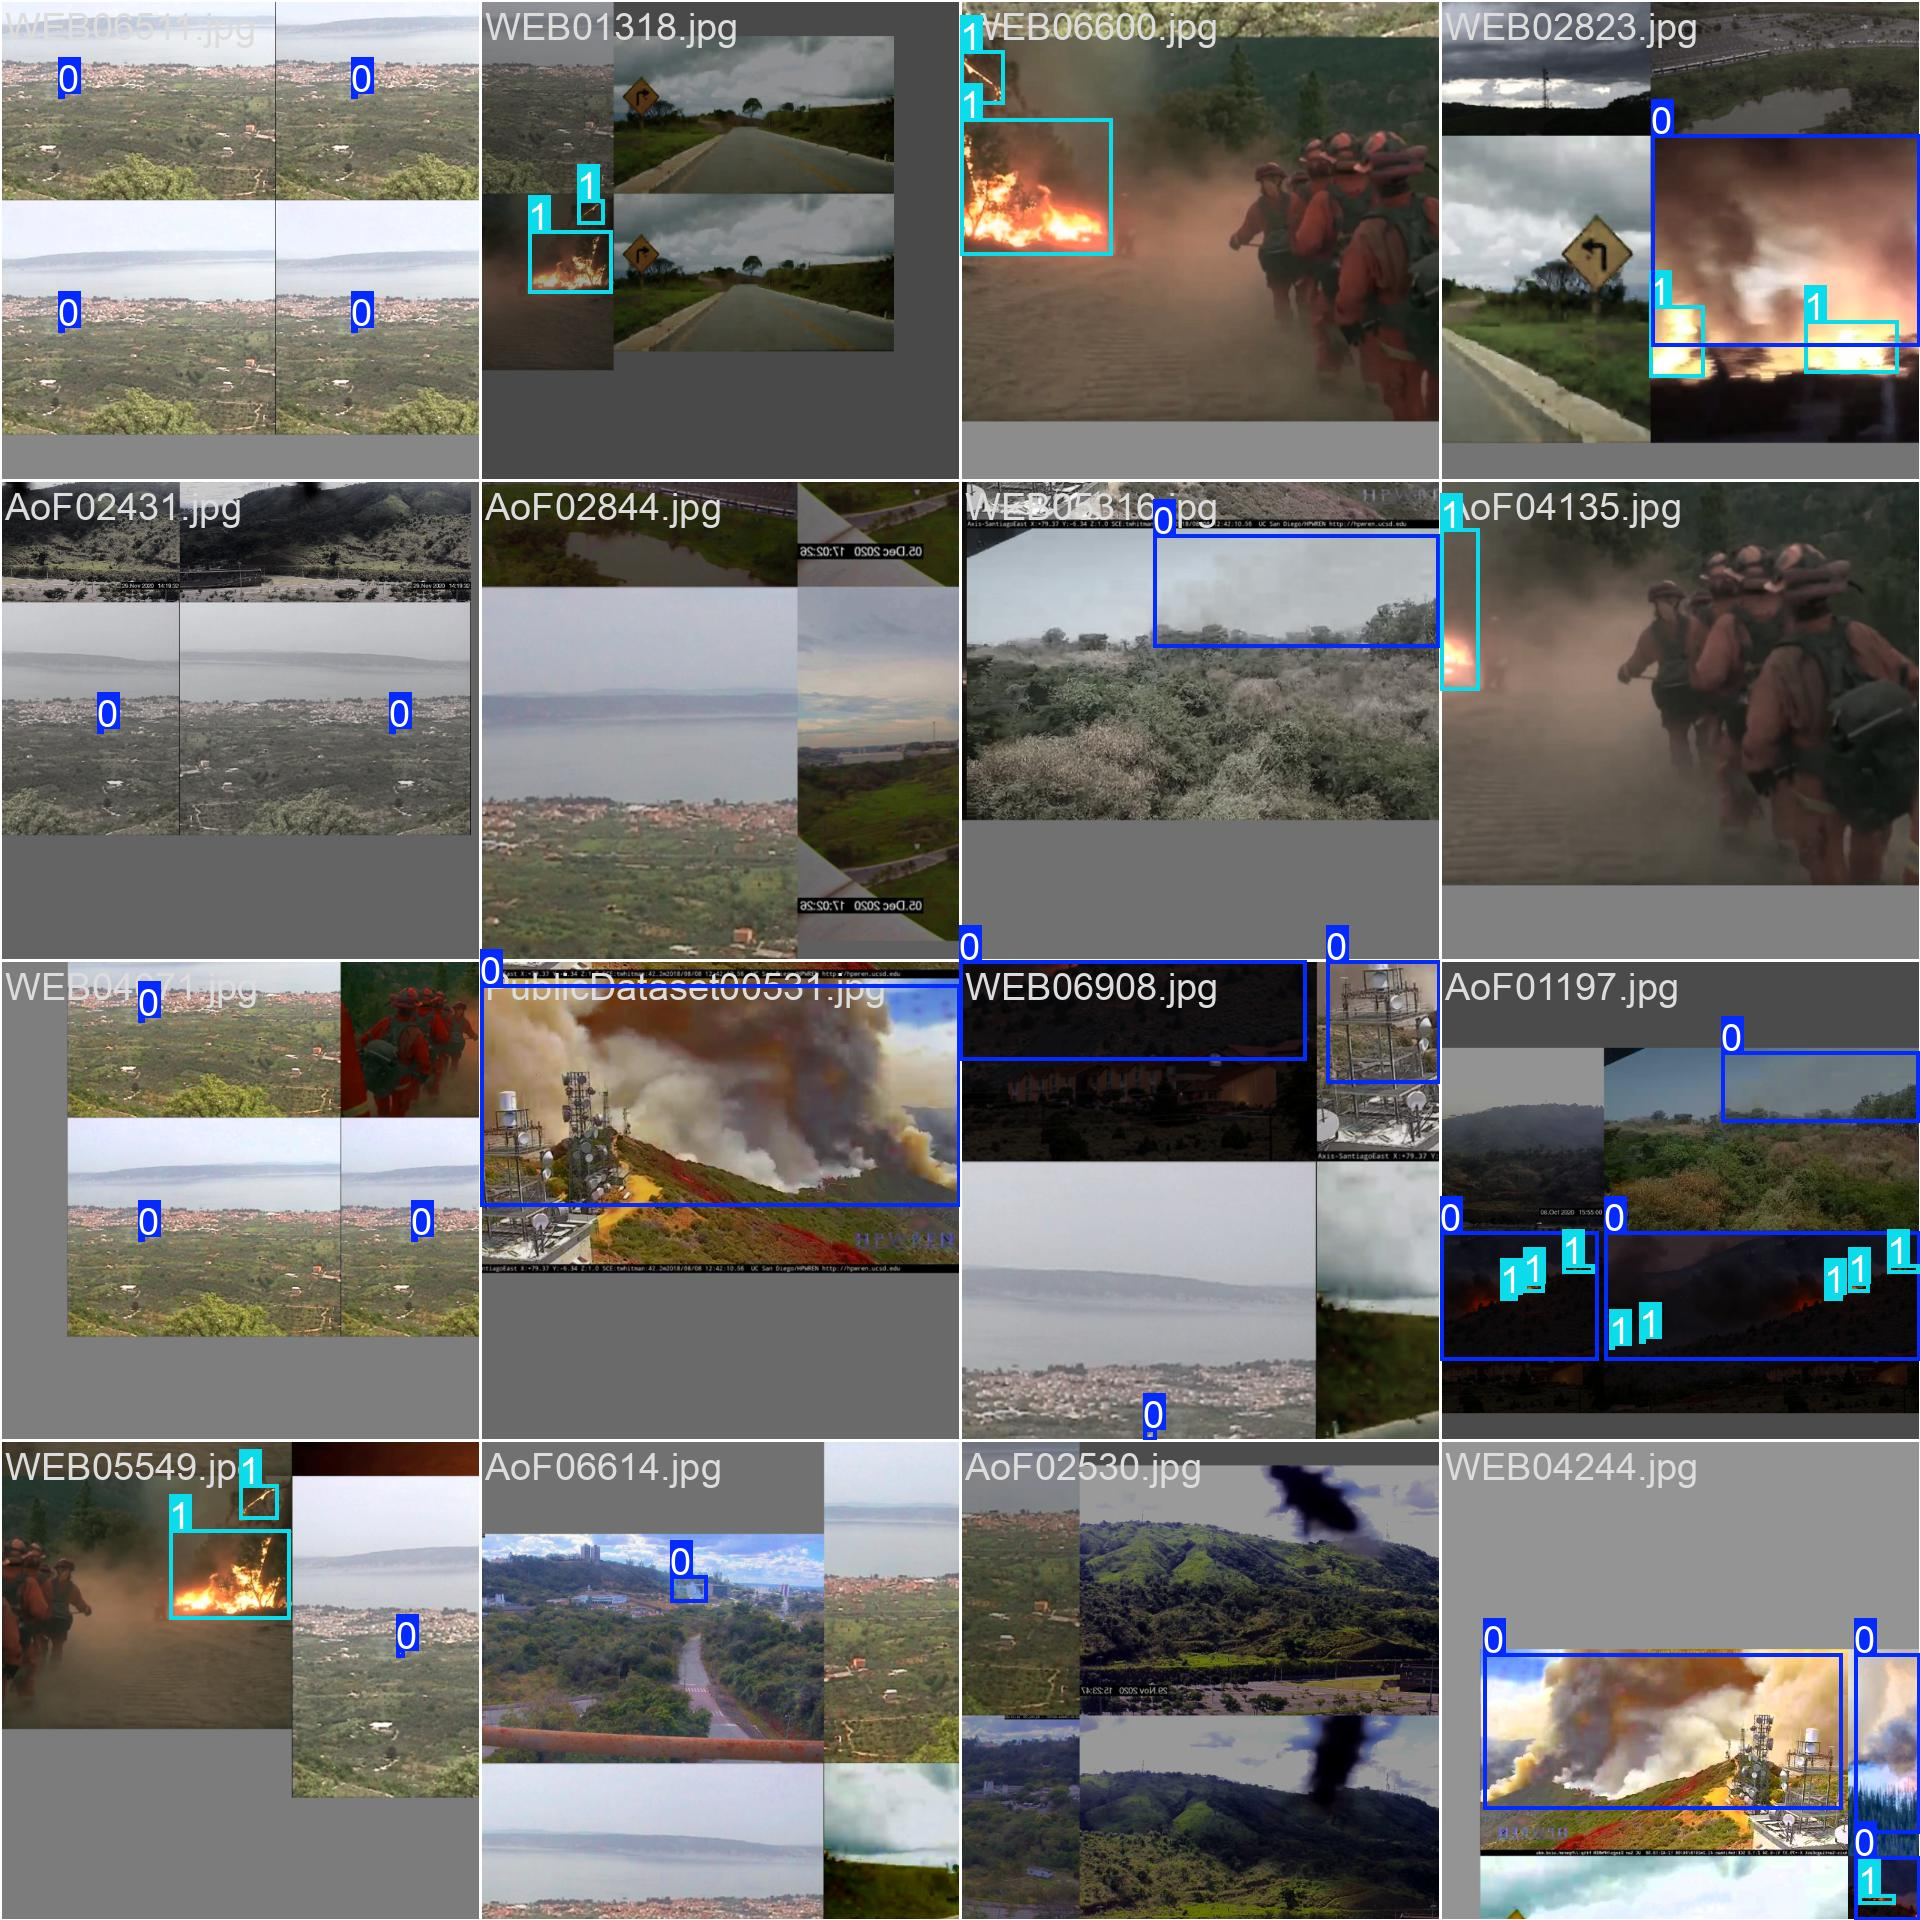

In [17]:
Image("/kaggle/working/runs/detect/train/train_batch0.jpg", width=600)


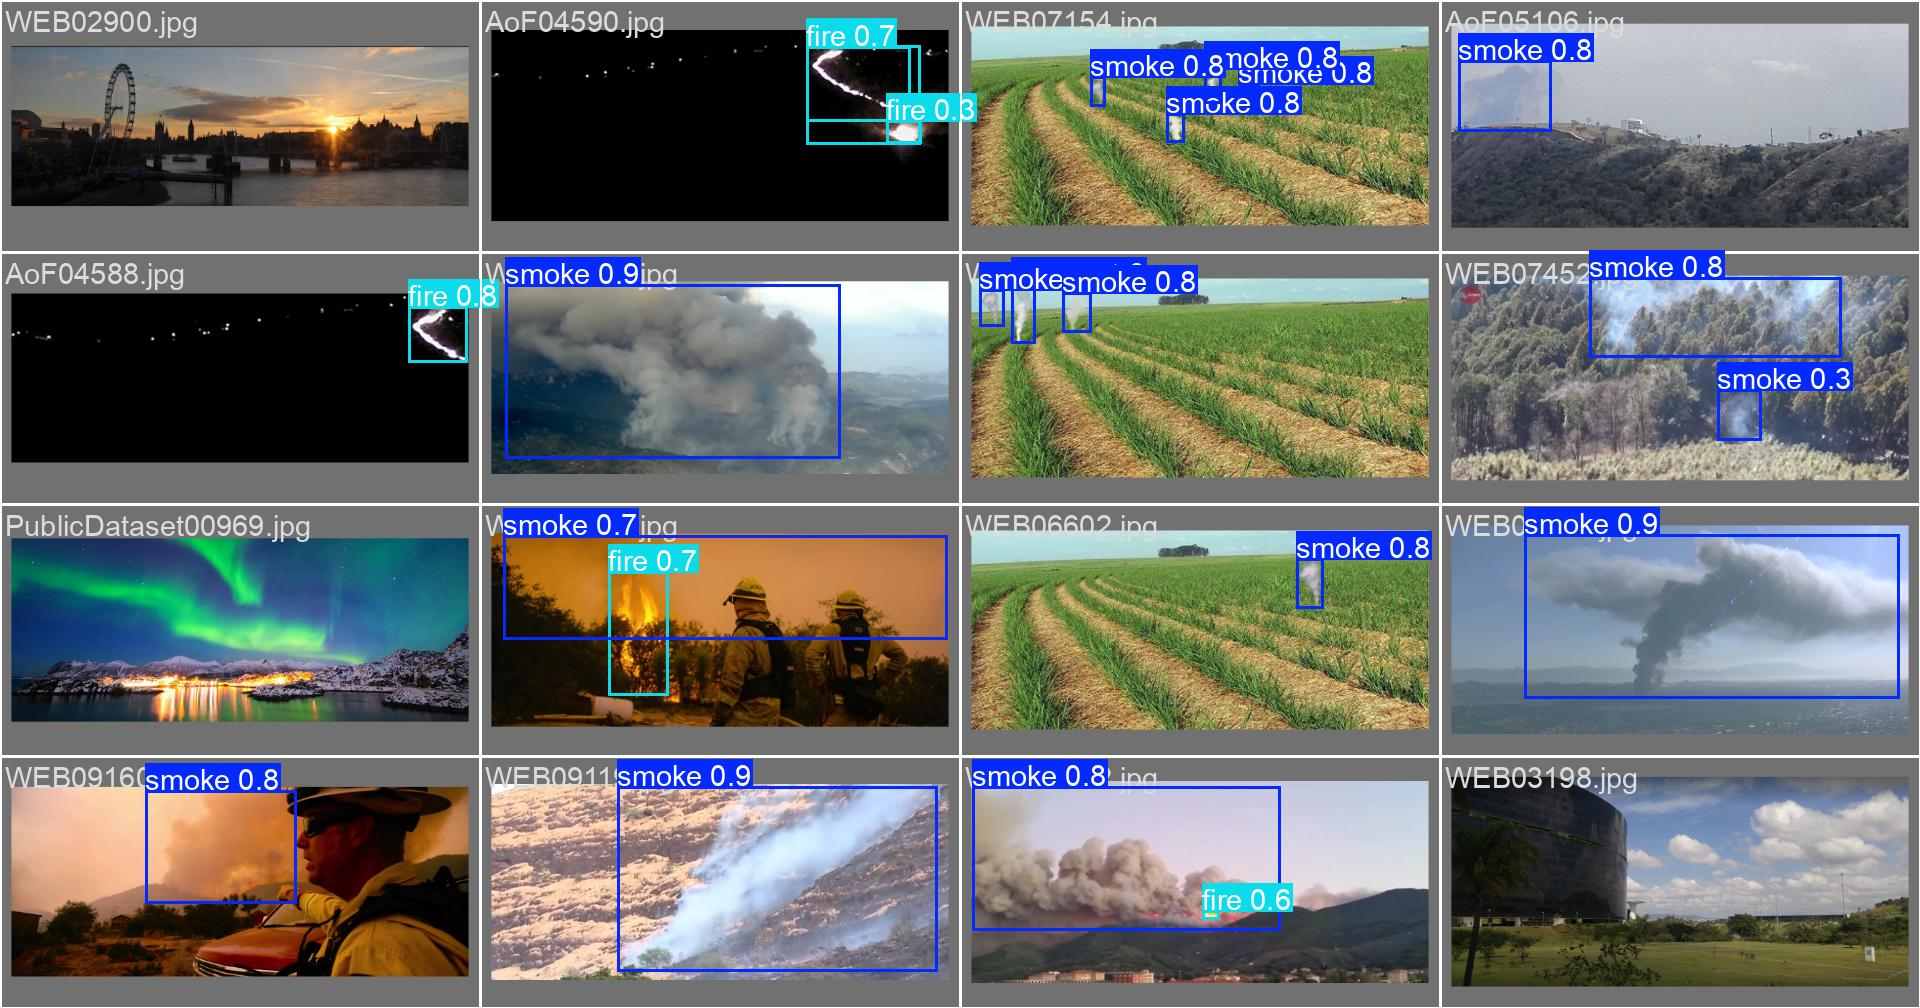

In [23]:
Image("/kaggle/working/runs/detect/train/val_batch0_pred.jpg", width=600)


In [ ]:
import os
import shutil
from ultralytics import YOLO

# 1. Let's find where the model actually is. 
# Based on your previous logs, it was in 'train3'
source = '/kaggle/working/runs/detect/train3/weights/best.pt'
target = '/kaggle/working/best_fire_smoke_model.pt'

# 2. Move it to the main working directory if it's not there yet
if os.path.exists(source):
    shutil.copy(source, target)
    print("✅ Model moved to /kaggle/working/")
else:
    print("⚠️ Could not find weights in 'train3'. checking if it's already in 'working'...")

# 3. Load the model (only one path needed)
if os.path.exists(target):
    model = YOLO(target) 
    print("🚀 Model loaded successfully!")
    
    # 4. Run prediction
    # Replace 'path_to_your_image.jpg' with a real image path from your test set
    # Example: '/kaggle/input/smoke-fire-detection-yolo/data/test/images/some_image.jpg'
    results = model.predict(source='path_to_your_image.jpg', save=True)
else:
    print("❌ Error: best_fire_smoke_model.pt still not found. Did the training finish?")

In [22]:
import shutil
import os

# This script copies the best weights to a visible location
source_path = '/kaggle/working/runs/detect/train3/weights/best.pt'
destination_path = '/kaggle/working/best_fire_smoke_model.pt'

if os.path.exists(source_path):
    shutil.copy(source_path, destination_path)
    print(f"Success! Model saved to: {destination_path}")
else:
    print("Error: Could not find the weight file. Check if training finished.")

Error: Could not find the weight file. Check if training finished.


In [ ]:
from ultralytics import YOLO

# Load your saved model
model = YOLO('/kaggle/working/best_fire_smoke_model.pt', '/kaggle/working/')


# Run prediction on a new image
results = model.predict(source='path_to_your_image.jpg', save=True)

In [24]:
from ultralytics import YOLO
import os

# 1. Load the specific model you see in your output
model_path = '/kaggle/working/yolo8s.pt'

if os.path.exists(model_path):
    model = YOLO(model_path)
    
    # 2. Grab one image from your test folder to try it out
    # I'll list the first image found in your test directory
    test_images_path = '/kaggle/input/smoke-fire-detection-yolo/data/test/images'
    sample_image = os.path.join(test_images_path, os.listdir(test_images_path)[0])
    
    # 3. Predict!
    results = model.predict(source=sample_image, save=True, conf=0.25)
    
    print(f"✅ Prediction finished! Results saved to: {results[0].save_dir}")
else:
    print(f"❌ Could not find {model_path}. Double check the spelling in the sidebar!")

❌ Could not find /kaggle/working/yolo8s.pt. Double check the spelling in the sidebar!



image 1/1 /kaggle/input/smoke-fire-detection-yolo/data/test/images/AoF06750.jpg: 384x640 (no detections), 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


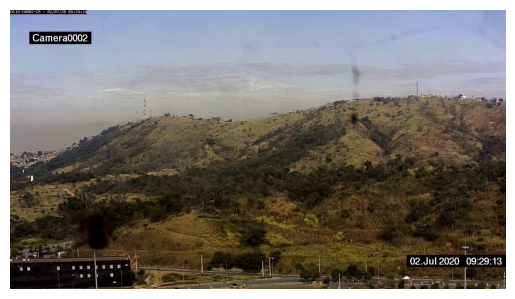

In [4]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# 1. Load the model you see in your Output sidebar
model = YOLO('/kaggle/working/yolo26n.pt')

# 2. Run prediction on a test image
# Replace the path below with an actual image path from your test set
image_path = '/kaggle/input/smoke-fire-detection-yolo/data/test/images/AoF06750.jpg'
results = model.predict(source=image_path, conf=0.25)

# 3. Display the result directly in your notebook
res_plotted = results[0].plot()
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [5]:
import urllib.request

# Sample fire video from a public repository
video_url = 'https://raw.githubusercontent.com/spacewalk01/yolov5-fire-detection/main/input.mp4'
video_path = '/kaggle/working/test_fire_video.mp4'

print("Downloading test video...")
urllib.request.urlretrieve(video_url, video_path)
print("✅ Download complete! File saved as test_fire_video.mp4")

✅ Download complete! File saved as test_fire_video.mp4


In [6]:
from ultralytics import YOLO

# 1. Load your model
model = YOLO('/kaggle/working/yolo26n.pt')

# 2. Run prediction
# show_labels=True and show_conf=True are ON by default
results = model.predict(
    source='/kaggle/working/test_fire_video.mp4', 
    save=True, 
    conf=0.25,      # Show anything with > 25% confidence
    line_width=2    # Makes labels easier to read on high-res video
)

print(f"Prediction labels and accuracy scores are saved in the video at: {results[0].save_dir}")


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/190) /kaggle/working/test_fire_video.mp4: 384x640 3 persons, 2 trucks, 10.4ms
video 1/1 (frame 2/190) /kaggle/working/test_fire_video.mp4: 384x640 3 persons, 2 trucks, 9.7ms
video 1/1 (frame 3/190) /kaggle/working/test_fire_video.mp4: 384x640 3 persons, 2 trucks, 9.6ms
video 1/1 (frame 4/190) /kaggle/working/test_fire_video.mp4: 384x640 2 persons, 3 trucks, 10.7ms
video 1/1 (frame 5/190) /kaggle/working/test_fire_video.mp4: 384x640 2 p

In [8]:
import numpy as np

# 1. Load your custom model
model = YOLO('/kaggle/working/yolo26n.pt')

# 2. Path to your test video
video_path = '/kaggle/working/test_fire_video.mp4'
cap = cv2.VideoCapture(video_path)

all_confidences = []
frame_count = 0
detections_count = 0

print("Processing video frames... ⏳")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Run inference on the current frame
    results = model(frame, verbose=False)[0]
    
    # Extract confidence scores from the boxes
    if results.boxes:
        conf_scores = results.boxes.conf.cpu().numpy()
        all_confidences.extend(conf_scores)
        detections_count += len(conf_scores)
    
    frame_count += 1

cap.release()

# 3. Calculate and display the results
if all_confidences:
    avg_accuracy = np.mean(all_confidences) * 100
    print(f"\n--- 📊 Performance Summary ---")
    print(f"Total Frames Processed: {frame_count}")
    print(f"Total Objects Detected: {detections_count}")
    print(f"Average Confidence (Accuracy): {avg_accuracy:.2f}%")
else:
    print("\n❌ No fire or smoke detected in this video at the current threshold.")

Processing video frames... ⏳

--- 📊 Performance Summary ---
Total Frames Processed: 190
Total Objects Detected: 1426
Average Confidence (Accuracy): 43.82%
